To perform hyperparameter optimization, use this script !<br>
Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [1]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [2]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [3]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
# Calculate the True North wind direction

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [8]:
# Calculate the True North current direction

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [9]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [10]:
# dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [11]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [12]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,198.585961,150.634332,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,92.310964,100.306234,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.052191,0.102997,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,139.632096,73.919853,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,205.028650,121.289202,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,275.302728,227.423990,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,359.892603,359.958291,0.525174,16.760001


In [13]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [14]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [15]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,251.408180,68.408246,0.122270,7.112664
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,254.458891,68.408246,0.122270,6.653538
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,259.749663,57.259552,0.099846,6.488697
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,266.724504,57.259552,0.099846,6.104632
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,174.494060,57.259552,0.099846,6.181707


In [16]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [17]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [18]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [19]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [20]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,268.966251,52.930471,0.104064,7.648595
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,260.985188,36.481737,0.104050,6.700397
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,269.893495,44.814586,0.092759,4.089472
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,262.226057,70.701850,0.093128,3.821501
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,246.881208,52.780582,0.086621,5.479353


In [21]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [22]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [23]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


In [24]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_ship2.hist(bins=50,figsize=(20,15))
# plt.show()

In [25]:
# df_ship2['curspeed'].hist(bins=50)
# plt.show()

In [26]:
# hhstats = df_ship2.describe()
# print(hhstats)

Feature Selection

In [27]:
# corr_matrix = df_ship2.corr()
# print(corr_matrix["sog"])

In [28]:
# dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
# dfship_corr.head()

In [29]:
# def correlation_heatmap(df,fontsize):
#     correlations = df.corr()

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.set(font_scale = fontsize)
#     sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
#     plt.show();
    
# correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

In [30]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truecurrentdir','truewinddir'],axis=1)
# correlation_heatmap(df_ship2,.6)

In [31]:
# dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

# correlation_heatmap(dfship_corrftf,1)

In [32]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_ship2.hist(bins=50,figsize=(20,15))
# plt.show()

In [33]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [34]:
# df_ship2.info()

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [35]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [36]:
X = imputer.transform(df_ship2)

In [37]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [38]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3506 non-null   float64
 2   surftemp             3506 non-null   float64
 3   windwaveswellheight  3506 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewavedir          3506 non-null   float64
 11  truenorthwinddir     3506 non-null   float64
 12  truenorthcurrentdir  3506 non-null   float64
dtypes: float64(13)
memory usage: 383.5 KB
None


Data Split for training and test data

In [39]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [40]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [41]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [42]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [43]:
# from sklearn.ensemble import RandomForestRegressor
# model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=230,
#                                   max_features=9,
#                                   random_state=42, 
#                                   )
# model_rfr_ftr_hpo.fit(x_train,y_train)

In [44]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 267,
                                            min_samples_split = 5,
                                            #min_samples_leaf = 2,
                                            max_features = 9,
                                            max_depth=136,
                                            bootstrap=False,
                                            random_state=42)
model_rfr_ftr_hpov.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)

ETR TRAINING

In [45]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42,
                                )
model_etr.fit(x_train,y_train)

ExtraTreesRegressor(random_state=42)

In [46]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpo = ExtraTreesRegressor(random_state=42,
                                n_estimators=400)
model_etr_hpo.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=400, random_state=42)

Modelling using Decision Tree Regressor

In [47]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [48]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=10,
                                  min_samples_leaf=9,
                                  max_features=12,
                                  max_depth=90)
model_dtr_hpov.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=90, max_features=12, min_samples_leaf=9,
                      min_samples_split=10)

Modelling using Multiple Linear Regression

In [49]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

In [99]:
import os
from graphviz import Source
from sklearn.tree import export_graphviz

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

dot_data = export_graphviz(
        model_dtr,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=x_train.columns.values.tolist(),
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

# save_fig("reg_tree")
# graph.format = "png"
# graph.render("file_name")

Saving figure reg_tree


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(model_rfr_ftr, 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph
graph.format = "png"
graph.render("file_name")

In [51]:
# from sklearn import tree

# def tree_visualization(width,height,model_type):
#     fn=x_train.columns
#     fig, axes = plt.subplots(figsize = (width,height), dpi=800)
#     tree.plot_tree(model_type.estimators_[0],
#                max_depth=3,
#                fontsize=8,
#                feature_names = fn);
#     plt.show()
#     #fig.savefig('rf_individualtree.png')

# tree_visualization(25,5,model_rfr_ftr_hpo)

In [52]:
# def model_importance(model_type):
#     mod_imp = model_type.feature_importances_
#     df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
#     print(df_mod_imp)

# model_importance(model_rfr_ftr_hpo)

Evaluation of RFR

In [53]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr_ftr)
display_scores(x_test,y_test,model_rfr_ftr)


R^2 score (Indicate model fit. Best Score = 1): 0.9333268032257093
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9333754786411396
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5595754274461966
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.7041758353758472
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.4071594324600003


Evaluation of model with FTR + HPO

In [54]:
# y_predicted = predict_y(x_test,model_rfr_ftr_hpo)
# display_scores(x_test,y_test,model_rfr_ftr_hpo)

Evaluation of DTR

In [55]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8327055175651206
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8332628451114233
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8398689005113961
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7668979083327356
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5681969800000015


Evaluation of MLR 

In [56]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6900649948787513
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.6903810725223082
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.1317723230533638
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.273410481310981
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.8840059353877834


In [57]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.054417
waveperiod               0.435771
surftemp                -0.060790
windwaveswellheight     -1.026484
draught                  2.057562
cog                     -0.114713
heading                  0.115328
windspeed                0.106314
curspeed                -0.558978
truewavedir              0.000205
truenorthwinddir        -0.000134
truenorthcurrentdir      0.001561


Saving model to local directory

In [58]:
# Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_ftr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

HPO pre evaluation

Hyperparameter Optimization

RFR HPO fot test data

In [59]:
# from pprint import pprint
# pprint(model_rfr_ftr.get_params())

In [60]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#             #    'max_features': max_features,
#             #    'max_depth': max_depth,
#             #    'min_samples_split': min_samples_split,
#             #    'min_samples_leaf': min_samples_leaf,
#             #    'bootstrap': bootstrap}
# pprint(random_grid)

In [61]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# # rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [62]:
# rf_random.best_params_

In [63]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# # base_model = model_rfr_ftr
# # base_model.fit(x_train, y_train)
# # rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# # best_random = rf_random.best_estimator_
# # rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# # print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# # print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# # print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# # print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# # print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

HPO for DTR test data

In [64]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [65]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_train, y_train)

In [66]:
# dt_random.best_params_

In [67]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

ETR

In [68]:
# from pprint import pprint
# pprint(model_etr.get_params())

In [69]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]

# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#                #'max_features': max_features,
#                #'max_depth': max_depth,
#                #'min_samples_split': min_samples_split,
#                #'min_samples_leaf': min_samples_leaf,
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [70]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [71]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_etr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = rf_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [72]:
# rf_random.best_params_

HPO for validation data 

In [73]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,21.771601,184.345879,0.144914,10.248966
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,25.671971,199.414773,0.246220,11.364678
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,32.436488,199.442652,0.284315,12.666946
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,50.510505,189.415252,0.300428,13.386999
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,74.157471,180.552404,0.262897,12.053293


In [74]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [75]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)

In [76]:
dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


In [77]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [78]:
xdate = imputer.transform(dfdate6)

In [79]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [80]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truewinddir','truecurrentdir'],axis=1)
y_date = dfdate6tr.sog

>1 0.398 (0.215)
>2 0.556 (0.230)
>3 0.591 (0.264)
>4 0.658 (0.245)
>5 0.688 (0.242)
>6 0.722 (0.224)
>7 0.735 (0.225)
>8 0.747 (0.218)
>9 0.748 (0.220)
>10 0.766 (0.196)
>11 0.759 (0.217)
>12 0.768 (0.206)


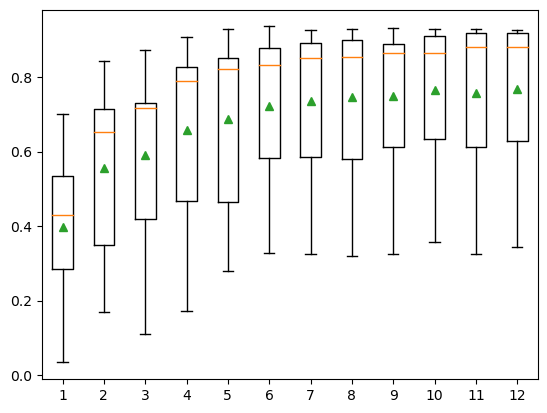

In [81]:
# explore random forest number of features effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# # get the dataset
# def get_dataset():
# 	X, y = x_test,y_test
# 	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for n in range(1,13):
		models[str(n)] = RandomForestRegressor(max_features=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='r2', cv=10, n_jobs=-1)
	return scores

# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, x_date, y_date)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.765 (0.209)
>50 0.766 (0.207)
>100 0.766 (0.204)
>500 0.765 (0.209)
>700 0.760 (0.212)
>800 0.762 (0.213)
>900 0.763 (0.213)
>1000 0.764 (0.210)


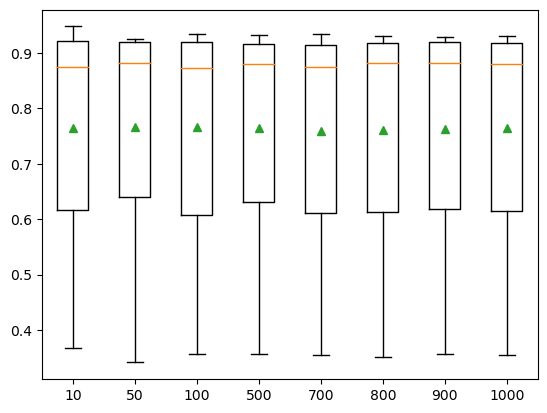

In [82]:
# explore random forest number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# get the dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# 	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500,700,800,900, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestRegressor(n_estimators=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='r2', cv=10, n_jobs=-1)
	return scores

# # define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, x_date, y_date)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.760 (0.209)
>100 0.766 (0.209)
>200 0.755 (0.219)
>300 0.760 (0.216)
>400 0.759 (0.215)
>500 0.757 (0.220)
>600 0.762 (0.218)
>700 0.778 (0.197)
>800 0.756 (0.217)
>900 0.752 (0.227)
>None 0.762 (0.204)


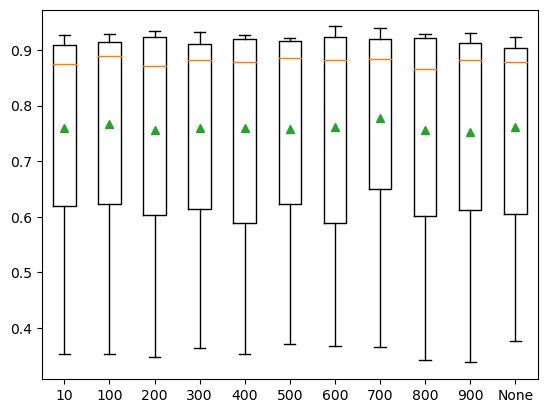

In [83]:
# explore random forest tree depth effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# # get the dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# 	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [10,100,200,300,400,500,600,700,800,900] + [None]
	for n in depths:
		models[str(n)] = RandomForestRegressor(max_depth=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='r2', cv=10, n_jobs=-1)
	return scores

# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, x_date, y_date)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

ETR HPO Validation Data

In [84]:
# from pprint import pprint
# pprint(model_etr.get_params())

In [85]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                #'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [86]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# etr_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# etr_random.fit(x_date, y_date)

In [87]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD
# base_model = model_etr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# etr_best_random = etr_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(etr_best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

RFR HPO Validation

In [88]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                #'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [89]:
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_date, y_date)

In [90]:
# rf_random.best_params_

In [91]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_ftr
# base_model.fit(x_date, y_date)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = rf_random.best_estimator_
# # best_random = model_rfr_ftr_hpov
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

DTR HPO Validation data 

In [92]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4, 5,6,7,8,9, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2,3,4,5,6,7,8,9,10]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [93]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_date, y_date)

In [94]:
# dt_random.best_params_

In [95]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [96]:
# print(dt_random.best_estimator_)